In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Git_Colab_Commit/Food_Classification

/content/drive/MyDrive/Git_Colab_Commit/Food_Classification


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
cd /content

/content


In [ ]:
!kaggle datasets download -d dansbecker/food-101

100% 9.37G/9.38G [04:04<00:00, 42.0MB/s]
100% 9.38G/9.38G [04:04<00:00, 41.1MB/s]


In [ ]:
!unzip /content/food-101.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: food-101/food-101/images/tacos/1030289.jpg  
  inflating: food-101/food-101/images/tacos/1033196.jpg  
  inflating: food-101/food-101/images/tacos/1036030.jpg  
  inflating: food-101/food-101/images/tacos/1042175.jpg  
  inflating: food-101/food-101/images/tacos/1044043.jpg  
  inflating: food-101/food-101/images/tacos/1058697.jpg  
  inflating: food-101/food-101/images/tacos/1059239.jpg  
  inflating: food-101/food-101/images/tacos/1059326.jpg  
  inflating: food-101/food-101/images/tacos/1066762.jpg  
  inflating: food-101/food-101/images/tacos/1070967.jpg  
  inflating: food-101/food-101/images/tacos/1073468.jpg  
  inflating: food-101/food-101/images/tacos/1075296.jpg  
  inflating: food-101/food-101/images/tacos/1085243.jpg  
  inflating: food-101/food-101/images/tacos/108529.jpg  
  inflating: food-101/food-101/images/tacos/1086014.jpg  
  inflating: food-101/food-101/images/tacos/108945.jpg  
  inflating: food-101/food-101/images/

In [ ]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

In [ ]:
# Check if GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

2.9.2
/device:GPU:0


In [ ]:
%cd food-101/

/content/food-101


In [ ]:
# Check the extracted dataset folder
!ls food-101/

images	license_agreement.txt  meta  README.txt


In [ ]:
os.listdir('food-101/images')

['eggs_benedict',
 'beef_tartare',
 'hot_and_sour_soup',
 'takoyaki',
 'onion_rings',
 'pho',
 'huevos_rancheros',
 'risotto',
 'peking_duck',
 'shrimp_and_grits',
 'chocolate_mousse',
 'beef_carpaccio',
 'gnocchi',
 'panna_cotta',
 'fried_rice',
 'lobster_roll_sandwich',
 'clam_chowder',
 'strawberry_shortcake',
 'baby_back_ribs',
 'scallops',
 'club_sandwich',
 'spaghetti_carbonara',
 'cup_cakes',
 'omelette',
 'cheesecake',
 'chocolate_cake',
 'miso_soup',
 'croque_madame',
 'spring_rolls',
 'lobster_bisque',
 'pizza',
 'poutine',
 'foie_gras',
 'ravioli',
 'bruschetta',
 'macarons',
 'french_fries',
 'baklava',
 'chicken_wings',
 'pulled_pork_sandwich',
 'pad_thai',
 'red_velvet_cake',
 'beignets',
 'pork_chop',
 'prime_rib',
 'french_toast',
 'oysters',
 'escargots',
 'samosa',
 'bibimbap',
 'nachos',
 'gyoza',
 'ice_cream',
 'steak',
 'edamame',
 'lasagna',
 'dumplings',
 'waffles',
 'spaghetti_bolognese',
 'sushi',
 '.DS_Store',
 'caprese_salad',
 'grilled_cheese_sandwich',
 'pa

In [ ]:
os.listdir('food-101/meta')

['test.txt',
 'labels.txt',
 'train.txt',
 'classes.txt',
 'train.json',
 'test.json']

In [ ]:
!head food-101/meta/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [ ]:
!head food-101/meta/classes.txt

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


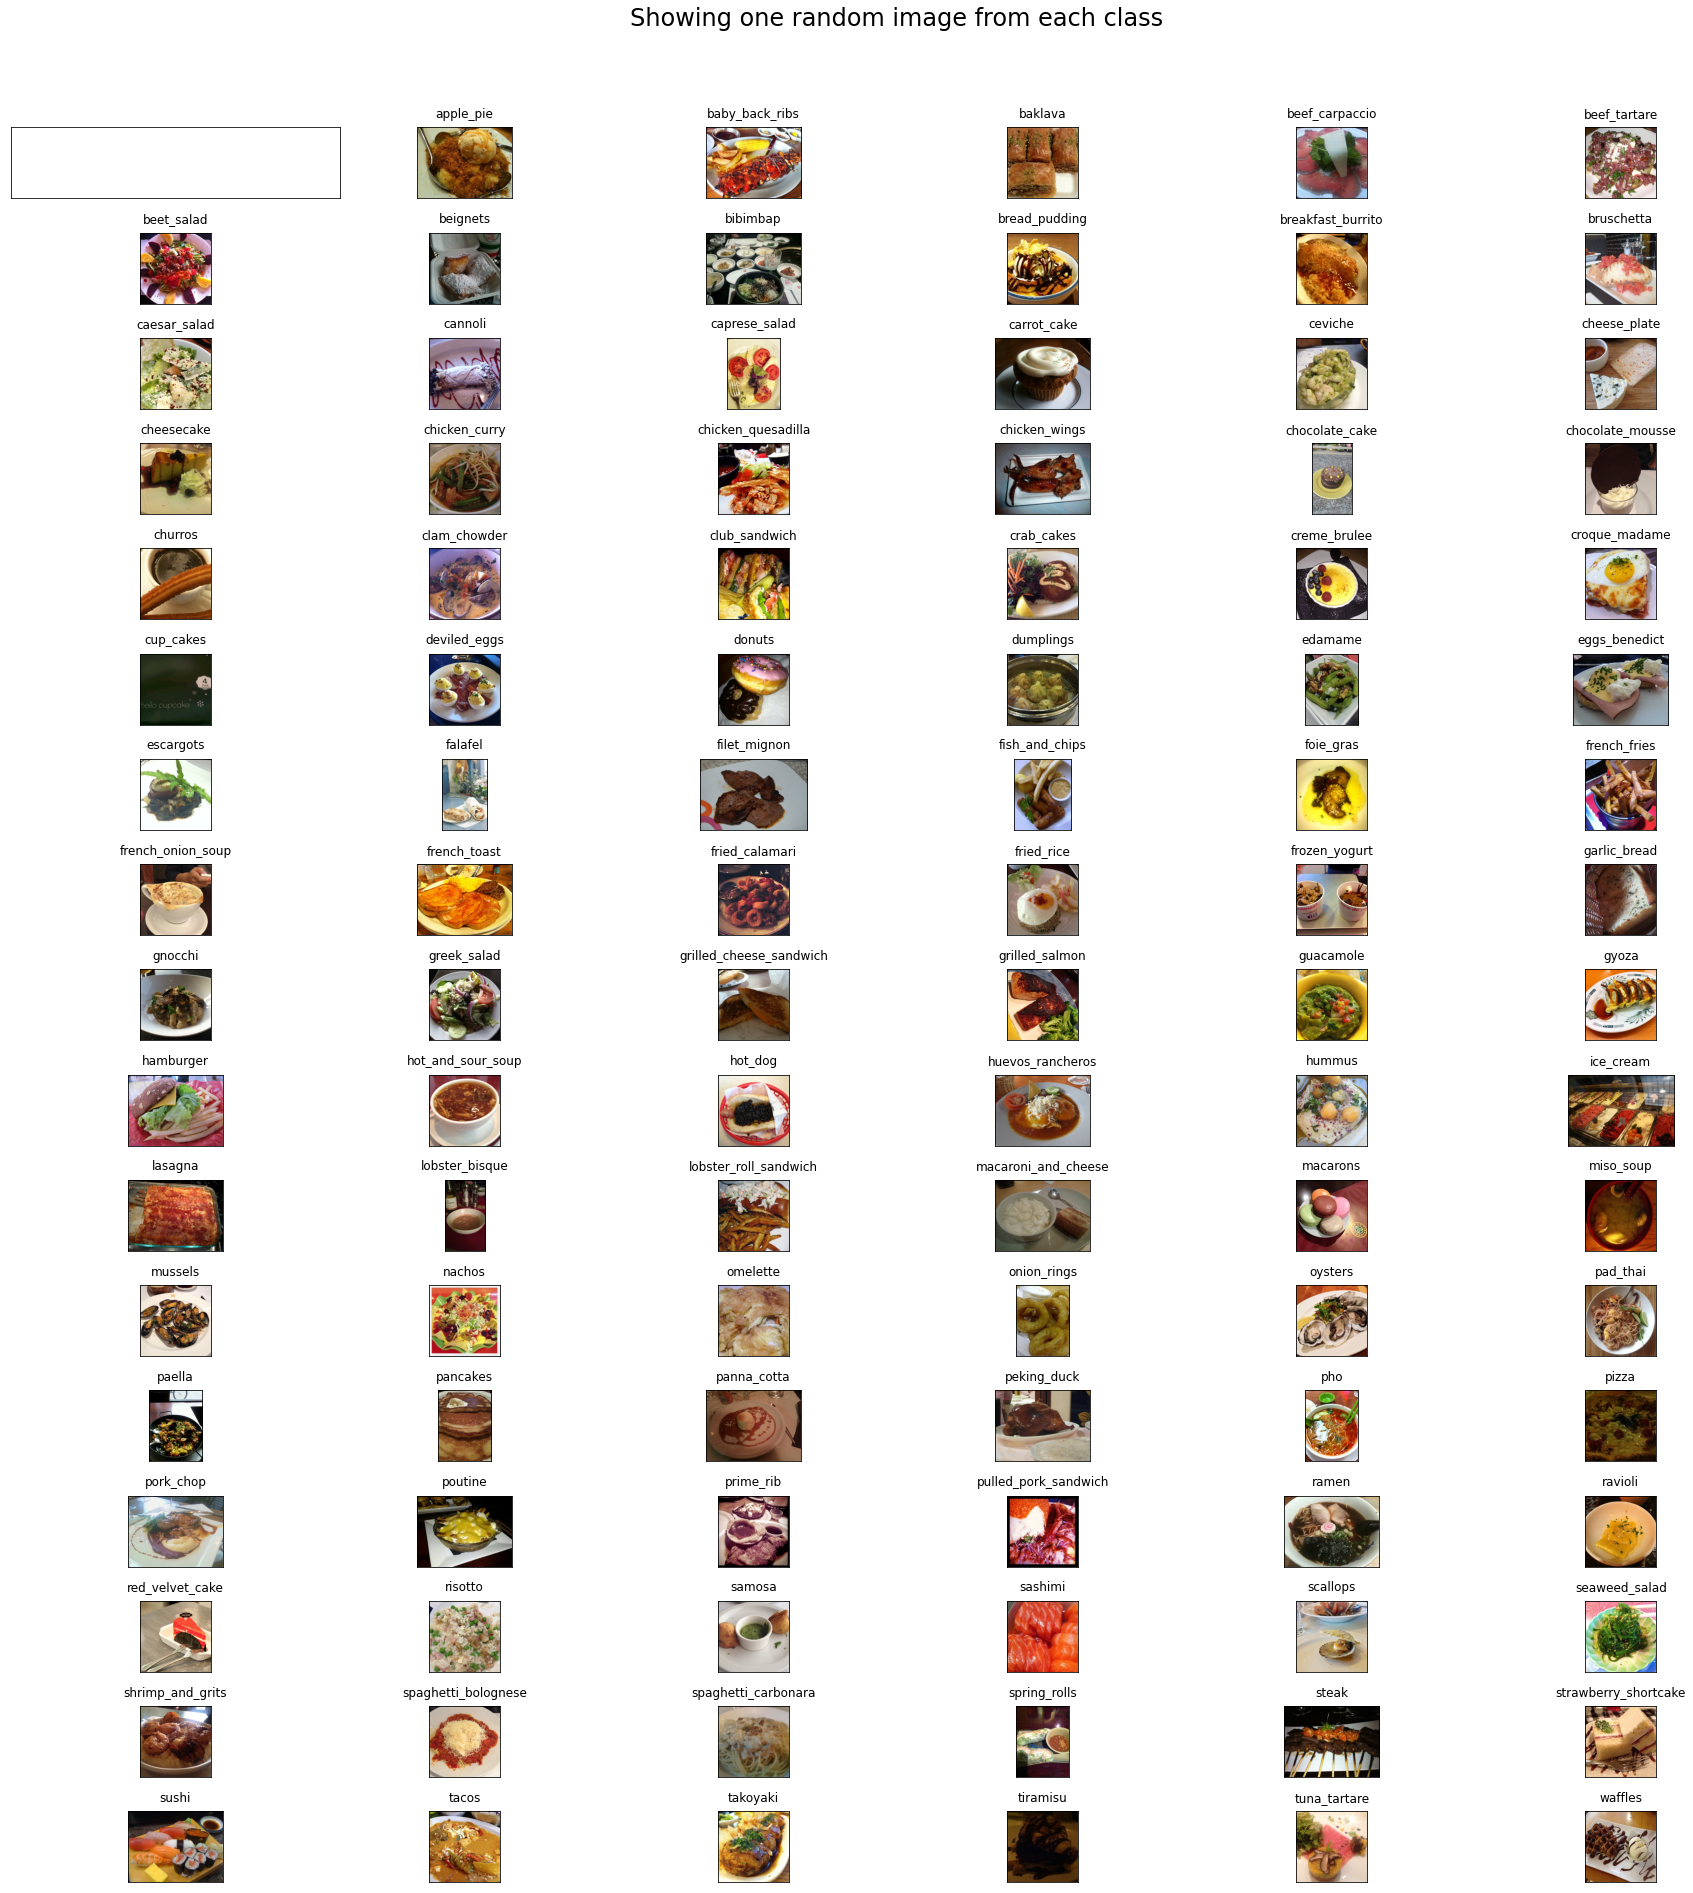

In [ ]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html


In [ ]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [ ]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
%cd /content/
print("Creating train data...")
prepare_data('food-101/food-101/meta/train.txt', 'food-101/food-101/images', 'train')

/content
Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

C

In [ ]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('food-101/food-101/meta/test.txt', 'food-101/food-101/images', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [ ]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [ ]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


In [ ]:
# List of all 101 types of foods(sorted alphabetically)
del foods_sorted[0] # remove .DS_Store from the list

In [ ]:
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))
      

In [ ]:
# picking 3 food items and generating separate data folders for the same
food_list = ['apple_pie','pizza','omelette']
src_train = 'train'
dest_train = 'train_mini'
src_test = 'test'
dest_test = 'test_mini'

In [ ]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [ ]:
print("Total number of samples in train folder")

!find train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
2250


In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [ ]:
print("Total number of samples in test folder")
!find test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
750


In [ ]:
K.clear_session()
n_classes = 3
img_width, img_height = 299, 299
train_data_dir = 'train_mini'
validation_data_dir = 'test_mini'
nb_train_samples = 2250 #75750
nb_validation_samples = 750 #25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_3class.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_3class.hdf5')

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.
87910968/87910968 [==============================] - 3s 0us/step


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
<ipython-input-29-b760b0c61731>:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/30
140/140 [==============================] - ETA: 0s - loss: 1.0748 - accuracy: 0.4521
Epoch 1: val_loss improved from inf to 0.88041, saving model to best_model_3class.hdf5
140/140 [==============================] - 85s 486ms/step - loss: 1.0748 - accuracy: 0.4521 - val_loss: 0.8804 - val_accuracy: 0.6454
Epoch 2/30
140/140 [==============================] - ETA: 0s - loss: 0.8613 - accuracy: 0.6723
Epoch 2: val_loss improved from 0.88041 to 0.68637, saving model to best_model_3class.hdf5
140/140 [==============================] - 63s 447ms/step - loss: 0.8613 - accuracy: 0.6723 - val_loss: 0.6864 - val_accuracy: 0.8043
Epoch 3/30
140/140 [==============================] - ETA: 0s - loss: 0.6990 - accuracy: 0.7596
Epoch 3: val_loss improved from 0.68637 to 0.53977, saving model to best_model_3class.hdf5
140/140 [==============================] - 65s 463ms/step - loss: 0.6990 - accuracy: 0.7596 - val_loss: 0.5398 - val_accuracy: 0.8560
Epoch 4/30
140/140 [=====================

In [ ]:
#!cp /content/model_trained_3class.hdf5 /content/drive/MyDrive/Git_Colab_Commit/Food_Classification

In [ ]:
class_map_3 = train_generator.class_indices
class_map_3

{'apple_pie': 0, 'omelette': 1, 'pizza': 2}

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


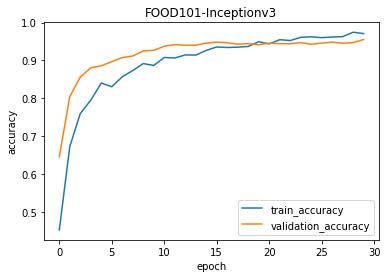

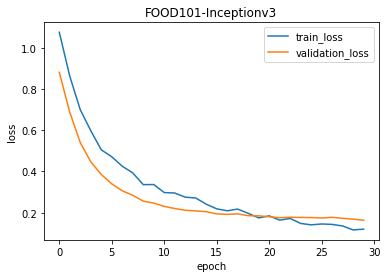

In [ ]:
plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

In [ ]:
%%time
# Loading the best saved model to make predictions
K.clear_session()
model_best = load_model('best_model_3class.hdf5',compile = False)

CPU times: user 2.58 s, sys: 195 ms, total: 2.77 s
Wall time: 2.83 s


In [ ]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

In [ ]:
# Downloading images from internet using the URLs
!wget -O samosa.jpg http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
!wget -O applepie.jpg https://acleanbake.com/wp-content/uploads/2017/10/Paleo-Apple-Pie-with-Crumb-Topping-gluten-free-grain-free-dairy-free-15.jpg
# If you have an image in your local computer and want to try it, uncomment the below code to upload the image files

from google.colab import files
sampleimage = files.upload()

--2023-01-08 09:36:26--  http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
Resolving veggiefoodrecipes.com (veggiefoodrecipes.com)... 45.77.209.234
Connecting to veggiefoodrecipes.com (veggiefoodrecipes.com)|45.77.209.234|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75560 (74K) [image/jpeg]
Saving to: ‘samosa.jpg’

samosa.jpg          100%[===================>]  73.79K   199KB/s    in 0.4s    

2023-01-08 09:36:27 (199 KB/s) - ‘samosa.jpg’ saved [75560/75560]

--2023-01-08 09:36:27--  https://acleanbake.com/wp-content/uploads/2017/10/Paleo-Apple-Pie-with-Crumb-Topping-gluten-free-grain-free-dairy-free-15.jpg
Resolving acleanbake.com (acleanbake.com)... 138.197.203.41
Connecting to acleanbake.com (acleanbake.com)|138.197.203.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114276 (112K) [image/jpeg]
Saving to: ‘applepie.jpg’

applepie.jpg        100%[===================>] 111.60K   392KB/s    in 0.

Saving omellet.jpg to omellet.jpg
Saving pizza.jpg to pizza.jpg


['/content/applepie.jpg', '/content/pizza.jpg', '/content/omellet.jpg']
1/1 [==============================] - 2s 2s/step


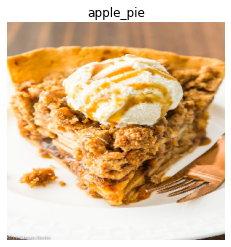

1/1 [==============================] - 0s 27ms/step


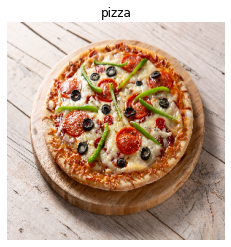

1/1 [==============================] - 0s 28ms/step


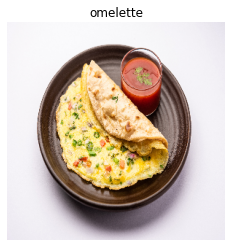

In [ ]:
# Make a list of downloaded images and test the trained model
images = []
images.append('/content/applepie.jpg')
images.append('/content/pizza.jpg')
images.append('/content/omellet.jpg')

print(images)
predict_class(model_best, images, True)

여기까지가 미니모델테스트(음식 3개)

In [ ]:
# Helper function to select n random food classes
def pick_n_random_classes(n):
  food_list = []
  random_food_indices = random.sample(range(len(foods_sorted)),n) # We are picking n random food classes
  for i in random_food_indices:
    food_list.append(foods_sorted[i])
  food_list.sort()
  return food_list
  

In [ ]:
# Lets try with more classes than just 3. Also, this time lets randomly pick the food classes
n = 11
food_list = pick_n_random_classes(n)
print(food_list)

# 랜덤으로 음식종류를 뽑았을 때 예시 중 하나
food_list = ['apple_pie', 'beef_carpaccio', 'bibimbap', 'cup_cakes', 'foie_gras', 'french_fries', 'garlic_bread', 'pizza', 'spring_rolls', 'spaghetti_carbonara', 'strawberry_shortcake']
print("These are the randomly picked food classes we will be training the model on...\n", food_list)

['baby_back_ribs', 'ceviche', 'chicken_wings', 'chocolate_mousse', 'gnocchi', 'hot_dog', 'macaroni_and_cheese', 'nachos', 'pad_thai', 'pancakes', 'spaghetti_bolognese']
These are the randomly picked food classes we will be training the model on...
 ['apple_pie', 'beef_carpaccio', 'bibimbap', 'cup_cakes', 'foie_gras', 'french_fries', 'garlic_bread', 'pizza', 'spring_rolls', 'spaghetti_carbonara', 'strawberry_shortcake']


In [ ]:
# Create the new data subset of n classes
print("Creating training data folder with new classes...")
dataset_mini(food_list, src_train, dest_train)

Creating training data folder with new classes...
Copying images into apple_pie
Copying images into beef_carpaccio
Copying images into bibimbap
Copying images into cup_cakes
Copying images into foie_gras
Copying images into french_fries
Copying images into garlic_bread
Copying images into pizza
Copying images into spring_rolls
Copying images into spaghetti_carbonara
Copying images into strawberry_shortcake


In [ ]:
print("Total number of samples in train folder")
!find train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
8250


In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into beef_carpaccio
Copying images into bibimbap
Copying images into cup_cakes
Copying images into foie_gras
Copying images into french_fries
Copying images into garlic_bread
Copying images into pizza
Copying images into spring_rolls
Copying images into spaghetti_carbonara
Copying images into strawberry_shortcake


In [ ]:
print("Total number of samples in test folder")
!find test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
2750


In [ ]:
# Let's use a pretrained Inceptionv3 model on subset of data with 11 food classes
K.clear_session()

n_classes = n
img_width, img_height = 299, 299
train_data_dir = 'train_mini'
validation_data_dir = 'test_mini'
nb_train_samples = 8250 #75750
nb_validation_samples = 2750 #25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(n,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_11class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_11class.log')

history_11class = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_11class.hdf5')


Found 8250 images belonging to 11 classes.
Found 2750 images belonging to 11 classes.


<ipython-input-44-758bd26ab4d0>:46: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_11class = model.fit_generator(train_generator,


Epoch 1/30
515/515 [==============================] - ETA: 0s - loss: 2.0697 - accuracy: 0.3942
Epoch 1: val_loss improved from inf to 1.32434, saving model to best_model_11class.hdf5
515/515 [==============================] - 243s 460ms/step - loss: 2.0697 - accuracy: 0.3942 - val_loss: 1.3243 - val_accuracy: 0.7390
Epoch 2/30
515/515 [==============================] - ETA: 0s - loss: 1.2296 - accuracy: 0.6926
Epoch 2: val_loss improved from 1.32434 to 0.74144, saving model to best_model_11class.hdf5
515/515 [==============================] - 233s 451ms/step - loss: 1.2296 - accuracy: 0.6926 - val_loss: 0.7414 - val_accuracy: 0.8341
Epoch 3/30
515/515 [==============================] - ETA: 0s - loss: 0.8841 - accuracy: 0.7769
Epoch 3: val_loss improved from 0.74144 to 0.54487, saving model to best_model_11class.hdf5
515/515 [==============================] - 229s 444ms/step - loss: 0.8841 - accuracy: 0.7769 - val_loss: 0.5449 - val_accuracy: 0.8765
Epoch 4/30
515/515 [===============

In [ ]:
#!cp /content/model_trained_11class.hdf5 /content/drive/MyDrive/Git_Colab_Commit/Food_Classification

In [ ]:
class_map_11 = train_generator.class_indices
class_map_11

{'apple_pie': 0,
 'beef_carpaccio': 1,
 'bibimbap': 2,
 'cup_cakes': 3,
 'foie_gras': 4,
 'french_fries': 5,
 'garlic_bread': 6,
 'pizza': 7,
 'spaghetti_carbonara': 8,
 'spring_rolls': 9,
 'strawberry_shortcake': 10}

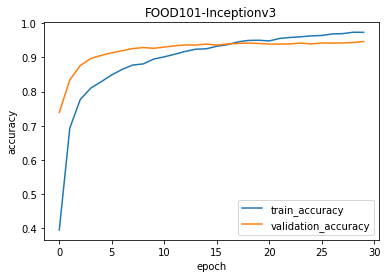

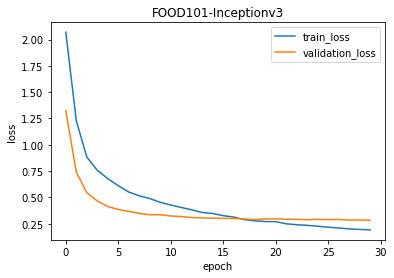

In [ ]:
plot_accuracy(history_11class,'FOOD101-Inceptionv3')
plot_loss(history_11class,'FOOD101-Inceptionv3')

In [ ]:
%%time
# Loading the best saved model to make predictions
K.clear_session()
model_best = load_model('best_model_11class.hdf5',compile = False)

CPU times: user 2.57 s, sys: 377 ms, total: 2.95 s
Wall time: 2.95 s


In [ ]:
# Downloading images from internet using the URLs
!wget -O cupcakes.jpg https://www.publicdomainpictures.net/pictures/110000/nahled/halloween-witch-cupcakes.jpg
!wget -O springrolls.jpg https://upload.wikimedia.org/wikipedia/commons/6/6f/Vietnamese_spring_rolls.jpg
!wget -O garlicbread.jpg https://c1.staticflickr.com/1/84/262952165_7ba3466108_z.jpg?zz=1

# If you have an image in your local computer and want to try it, uncomment the below code to upload the image files


# from google.colab import files
# image = files.upload()

--2023-01-08 12:45:57--  https://www.publicdomainpictures.net/pictures/110000/nahled/halloween-witch-cupcakes.jpg
Resolving www.publicdomainpictures.net (www.publicdomainpictures.net)... 172.67.2.204, 104.20.44.162, 104.20.45.162, ...
Connecting to www.publicdomainpictures.net (www.publicdomainpictures.net)|172.67.2.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51698 (50K) [image/jpeg]
Saving to: ‘cupcakes.jpg’

cupcakes.jpg        100%[===================>]  50.49K  --.-KB/s    in 0.004s  

2023-01-08 12:45:58 (13.3 MB/s) - ‘cupcakes.jpg’ saved [51698/51698]

--2023-01-08 12:45:58--  https://upload.wikimedia.org/wikipedia/commons/6/6f/Vietnamese_spring_rolls.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4154557 (4.0M) [image/jpeg]
Saving to: ‘springrolls.jpg

1/1 [==============================] - 2s 2s/step


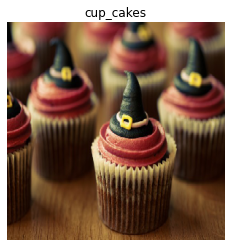

1/1 [==============================] - 0s 28ms/step


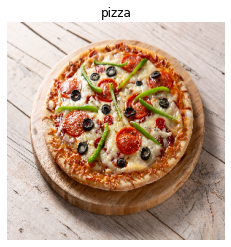

1/1 [==============================] - 0s 26ms/step


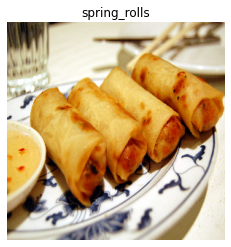

1/1 [==============================] - 0s 33ms/step


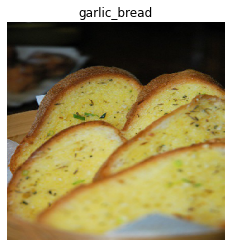

In [ ]:
# Make a list of downloaded images and test the trained model
images = []
images.append('cupcakes.jpg')
images.append('pizza.jpg')
images.append('springrolls.jpg')
images.append('garlicbread.jpg')
predict_class(model_best, images, True)

여기까지가 샘플 11개 테스트

In [ ]:
# Load the saved model trained with 3 classes
K.clear_session()
print("Loading the model..")
model = load_model('best_model_3class.hdf5',compile = False)
print("Done!")


Loading the model..
Done!


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [ ]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [ ]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

In [ ]:
def get_activations(img, model_activations):
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255. 
    plt.imshow(img[0])
    plt.show()
    return model_activations.predict(img)
    

In [ ]:
def show_activations(activations, layer_names):
    
    images_per_row = 16

    # Now let's display our feature maps
    for layer_name, layer_activation in zip(layer_names, activations):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]

        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]

        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

    plt.show()



In [ ]:
len(model.layers)

315

In [ ]:
# We start with index 1 instead of 0, as input layer is at index 0
layers = [layer.output for layer in model.layers[1:11]]
# We now initialize a model which takes an input and outputs the above chosen layers
activations_output = models.Model(inputs=model.input, outputs=layers)

In [ ]:
layers

[<KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'batch_normalization')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'activation')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'batch_normalization_1')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'activation_1')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'conv2d_2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'batch_normalization_2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'activation_2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'max_pooling2d')>]

In [ ]:
layer_names = []
for layer in model.layers[1:11]:
    layer_names.append(layer.name)
print(layer_names)

['conv2d', 'batch_normalization', 'activation', 'conv2d_1', 'batch_normalization_1', 'activation_1', 'conv2d_2', 'batch_normalization_2', 'activation_2', 'max_pooling2d']


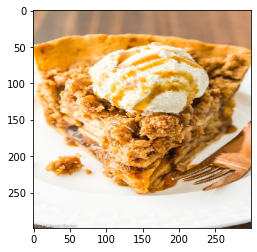

1/1 [==============================] - 0s 216ms/step


In [ ]:
food = 'applepie.jpg'
activations = get_activations(food,activations_output)

In [ ]:
show_activations(activations, layer_names)

Output hidden; open in https://colab.research.google.com to view.

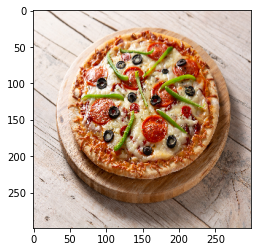

1/1 [==============================] - 0s 16ms/step


In [ ]:
food = 'pizza.jpg'
activations = get_activations(food,activations_output)

In [ ]:
show_activations(activations, layer_names)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Get the index of activation_1 layer which has sparse activations
ind = layer_names.index('activation_1')
sparse_activation = activations[ind]
a = sparse_activation[0, :, :, 13]
a

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [ ]:
all (np.isnan(a[j][k])  for j in range(a.shape[0]) for k in range(a.shape[1]))

True

In [ ]:
# Get the index of batch_normalization_1 layer which has sparse activations
ind = layer_names.index('batch_normalization_1')
sparse_activation = activations[ind]
b = sparse_activation[0, :, :, 13]
b

array([[51.144867, 51.144867, 51.144867, ..., 59.37935 , 56.63452 ,
        51.144867],
       [51.144867, 53.889694, 51.144867, ..., 56.63452 , 56.63452 ,
        59.37935 ],
       [51.144867, 51.144867, 51.144867, ..., 51.144867, 53.889694,
        56.63452 ],
       ...,
       [62.124176, 45.655212, 48.40004 , ..., 62.124176, 64.869   ,
        70.35865 ],
       [51.144867, 45.655212, 48.40004 , ..., 56.63452 , 70.35865 ,
        73.10348 ],
       [53.889694, 56.63452 , 45.655212, ..., 56.63452 , 73.10348 ,
        64.869   ]], dtype=float32)

Text(0.5, 1.0, 'Conv2d_3')

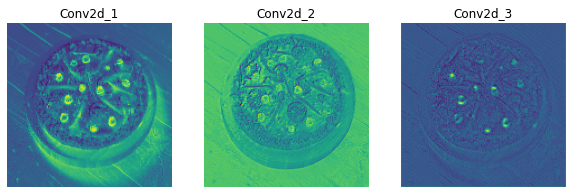

In [ ]:
first_convlayer_activation = activations[0]
second_convlayer_activation = activations[3]
third_convlayer_activation = activations[6]
f,ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(first_convlayer_activation[0, :, :, 3], cmap='viridis')
ax[0].axis('OFF')
ax[0].set_title('Conv2d_1')
ax[1].imshow(second_convlayer_activation[0, :, :, 3], cmap='viridis')
ax[1].axis('OFF')
ax[1].set_title('Conv2d_2')
ax[2].imshow(third_convlayer_activation[0, :, :, 3], cmap='viridis')
ax[2].axis('OFF')
ax[2].set_title('Conv2d_3')


In [ ]:
def get_attribution(food):
    img = image.load_img(food, target_size=(299, 299))
    img = image.img_to_array(img) 
    img /= 255. 
    f,ax = plt.subplots(1,3, figsize=(15,15))
    ax[0].imshow(img)
    
    img = np.expand_dims(img, axis=0) 
    
    preds = model.predict(img)
    class_id = np.argmax(preds[0])
    ax[0].set_title("Input Image")
    class_output = model.output[:, class_id]
    last_conv_layer = model.get_layer("mixed10")
    
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([img])
    for i in range(2048):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    ax[1].imshow(heatmap)
    ax[1].set_title("Heat map")
    
    
    act_img = cv2.imread(food)
    heatmap = cv2.resize(heatmap, (act_img.shape[1], act_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(act_img, 0.6, heatmap, 0.4, 0)
    cv2.imwrite('classactivation.png', superimposed)
    img_act = image.load_img('classactivation.png', target_size=(299, 299))
    ax[2].imshow(img_act)
    ax[2].set_title("Class Activation")
    plt.show()
    return preds

In [ ]:
print("Showing the class map..")
print(class_map_3)

Showing the class map..
{'apple_pie': 0, 'omelette': 1, 'pizza': 2}


1/1 [==============================] - 0s 27ms/step


RuntimeError: ignored

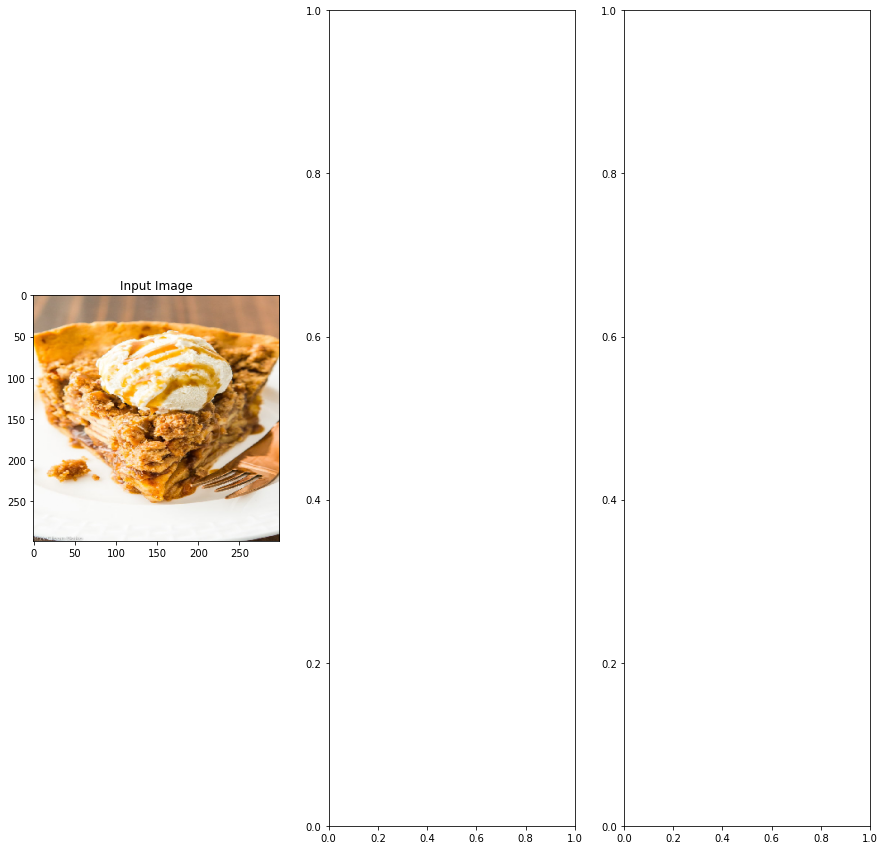

In [ ]:
pred = get_attribution('applepie.jpg')
print("Here are softmax predictions..",pred)

1/1 [==============================] - 0s 95ms/step


RuntimeError: ignored

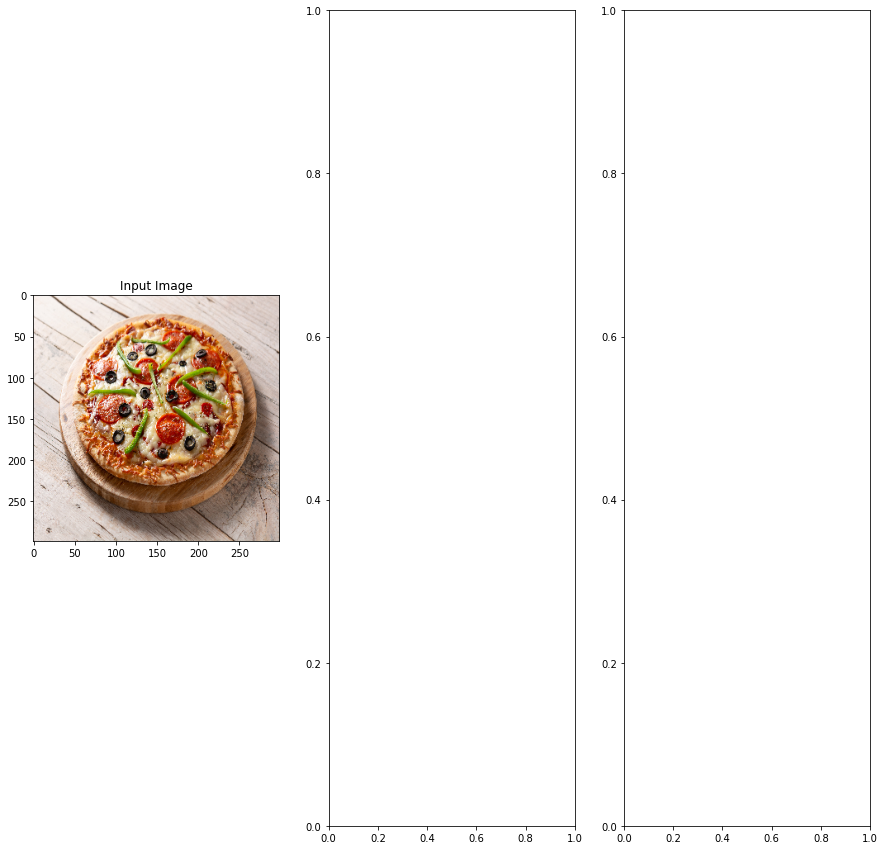

In [ ]:
pred = get_attribution('pizza.jpg')
print("Here are softmax predictions..",pred)

In [ ]:
!wget -O piepizza.jpg https://raw.githubusercontent.com/theimgclist/PracticeGround/master/Food101/piepizza.jpg
!wget -O piepizzas.png https://raw.githubusercontent.com/theimgclist/PracticeGround/master/Food101/piepizzas.png
!wget -O pizzapie.jpg https://raw.githubusercontent.com/theimgclist/PracticeGround/master/Food101/pizzapie.jpg
!wget -O pizzapies.png https://raw.githubusercontent.com/theimgclist/PracticeGround/master/Food101/pizzapies.png    

--2023-01-08 13:34:21--  https://raw.githubusercontent.com/theimgclist/PracticeGround/master/Food101/piepizza.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70232 (69K) [image/jpeg]
Saving to: ‘piepizza.jpg’

piepizza.jpg        100%[===================>]  68.59K  --.-KB/s    in 0.004s  

2023-01-08 13:34:21 (17.4 MB/s) - ‘piepizza.jpg’ saved [70232/70232]

--2023-01-08 13:34:22--  https://raw.githubusercontent.com/theimgclist/PracticeGround/master/Food101/piepizzas.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 415642 (

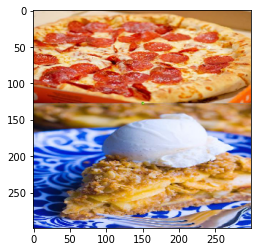

1/1 [==============================] - 0s 34ms/step


In [ ]:
food = 'piepizza.jpg'
activations = get_activations(food,activations_output)

In [ ]:
show_activations(activations, layer_names)

Output hidden; open in https://colab.research.google.com to view.

1/1 [==============================] - 0s 59ms/step


RuntimeError: ignored

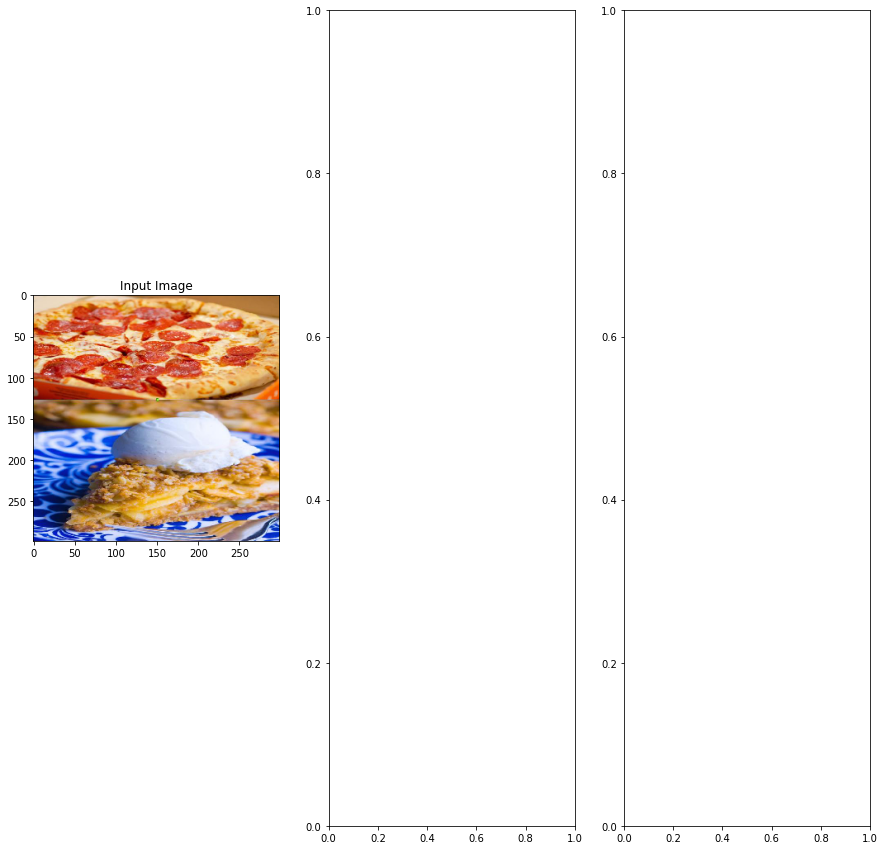

In [ ]:
pred = get_attribution('piepizza.jpg')
print("Here are softmax predictions..",pred)